In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import torchgp

In [2]:
def get_data(shuffle=False):
    x_train = np.loadtxt("./data/1d_x.txt", delimiter=",").reshape(-1, 1)
    y_train = np.loadtxt("./data/1d_y.txt", delimiter=",").reshape(-1, 1)
    num_train = len(y_train)
    batch_size = num_train // 3
    # Move the first third of the data to the left by 1
    x_train[:batch_size, :] -= 1
    # Move the second third of the data to the right by 1
    x_train[2 * batch_size : 3 * batch_size, :] += 1
    if shuffle:
        indices = np.random.permutation(x_train)
        x_train = x_train[indices, :]
        y_train = y_train[indices, :]
    x_test = np.linspace(-2.0, 12.0, 100)[:, None]
    return x_train, y_train, x_test

In [3]:
def plot_result(
    ax,
    x_train,
    y_train,
    x_test,
    mean,
    var,
    noise_variance,
    x_pseudo=None,
    f_pseudo=None,
    x_old=None,
    y_old=None,
    plot_legend=False,
):
    x_test = x_test.ravel()
    mean = mean.ravel()
    std = np.sqrt(var.ravel())
    noise_std = np.sqrt(noise_variance)

    ax.plot(x_train, y_train, "kx", mew=1, alpha=0.8, label="Training")
    if x_old is not None and y_old is not None:
        ax.plot(x_old, y_old, "kx", mew=1, alpha=0.2, label="Old")
    ax.plot(x_test, mean, "b", lw=2, label="Mean")
    ax.fill_between(
        x_test.ravel(),
        mean - 2 * std,
        mean + 2 * std,
        color="b",
        alpha=0.3,
        label="±2σ(f)",
    )
    ax.fill_between(
        x_test.ravel(),
        mean - 2 * std - 2 * noise_std,
        mean + 2 * std + 2 * noise_std,
        color="c",
        alpha=0.2,
        label="±2σ(y)",
    )
    if x_pseudo is not None and f_pseudo is not None:
        ax.plot(x_pseudo, f_pseudo, "ro", mew=1, alpha=0.8, label="Pseudo")
    ax.set_ylim([-3.0, 3.0])
    ax.set_xlim([np.min(x_test), np.max(x_test)])
    plt.subplots_adjust(hspace=0.08)
    ax.set_ylabel("y")
    ax.yaxis.set_ticks(np.arange(-2, 3, 1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%0.1f"))
    if plot_legend:
        ax.legend(
            loc="lower center",
            bbox_to_anchor=(0.5, -0.6),
            fancybox=True,
            shadow=True,
            ncol=5,
        )


In [4]:
init_output_scale = 1.0
init_input_scale = 0.8
init_noise_variance = 0.001

In [5]:
x_train, y_train, x_test = get_data()

In [6]:
kernel = torchgp.kernels.GaussianKernel(input_scale=init_input_scale, output_scale=init_output_scale)
model = torchgp.models.GPRModel(kernel, noise_variance=init_noise_variance)

In [7]:
model.add_data(x_train, y_train)

In [8]:
model.learn(verbose=True)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19510D+03    |proj g|=  4.33144D+03

At iterate    1    f=  1.43081D+03    |proj g|=  1.55506D+03

At iterate    2    f=  7.58327D+02    |proj g|=  8.60193D+02

At iterate    3    f=  3.32818D+02    |proj g|=  3.99642D+02

At iterate    4    f=  1.59954D+02    |proj g|=  1.93138D+02

At iterate    5    f=  8.47004D+01    |proj g|=  8.55769D+01

At iterate    6    f=  5.85846D+01    |proj g|=  3.37830D+01

At iterate    7    f=  5.16304D+01    |proj g|=  1.01298D+01

At iterate    8    f=  5.01427D+01    |proj g|=  5.26285D+00

At iterate    9    f=  4.94235D+01    |proj g|=  4.06299D+00

At iterate   10    f=  4.90916D+01    |proj g|=  3.99547D+00

At iterate   11    f=  4.89489D+01    |proj g|=  1.08982D+00

At iterate   12    f=  4.89354D+01    |proj g|=  2.57758D-01

At iterate   13    f=  4.8

 This problem is unconstrained.


In [9]:
mean, var = model.predict(x_test, include_likelihood=False)

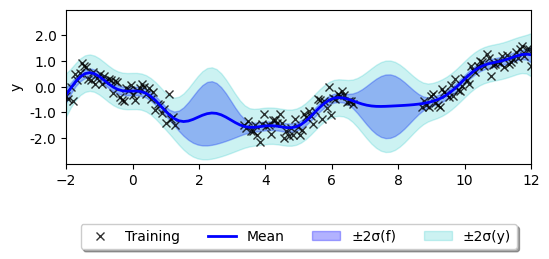

In [10]:
fig, ax = plt.subplots(figsize=(6, 2))
plot_result(
    ax,
    x_train,
    y_train,
    x_test,
    mean,
    var,
    model.likelihood.noise_variance.item(),
    plot_legend=True
)
plt.show()